# NIFTY50 LSTM Forecasting - Corrected Edition

**A Realistic Implementation of LSTM-based Financial Time Series Forecasting**

## 🎯 Corrected Approach

This notebook provides a **realistic and honest** implementation of LSTM models for financial forecasting, focusing on:

- **Three Core Models**: Original, Enhanced, and Optimized LSTM architectures
- **Realistic Performance**: Targeting 55-65% directional accuracy (industry standard)
- **Proper Validation**: Time-series appropriate train/test splits
- **Educational Focus**: Learning tool rather than trading system
- **Honest Metrics**: No inflated or impossible performance claims

### ⚠️ Important Disclaimers

1. **Educational Purpose**: This is a learning exercise, not financial advice
2. **Realistic Expectations**: Financial markets are largely unpredictable
3. **No Trading Recommendations**: Results should not be used for actual trading
4. **Risk Warning**: All investments carry substantial risk of loss

## 1. Import Libraries and Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from datetime import datetime
import joblib

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print("\n✅ Libraries imported successfully")

TensorFlow version: 2.19.0
Pandas version: 2.3.1
NumPy version: 2.3.2

✅ Libraries imported successfully


## 2. Configuration and Constants

In [2]:
# Project configuration
CSV_PATH = "nifty50_data.csv"
LOOKBACK_WINDOW = 60  # Number of days to look back
TEST_SPLIT = 0.2      # 20% for testing
VAL_SPLIT = 0.2       # 20% of training for validation
RANDOM_STATE = 42

# Create artifacts directory for corrected models
ARTIFACTS_DIR = Path("artifacts_corrected")
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Model configurations
MODELS_TO_BUILD = ['original', 'enhanced', 'optimized']

# Training parameters
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 10  # Early stopping patience

print(f"Configuration:")
print(f"  Data file: {CSV_PATH}")
print(f"  Lookback window: {LOOKBACK_WINDOW} days")
print(f"  Test split: {TEST_SPLIT * 100}%")
print(f"  Validation split: {VAL_SPLIT * 100}%")
print(f"  Models to build: {MODELS_TO_BUILD}")
print(f"  Artifacts directory: {ARTIFACTS_DIR}")

Configuration:
  Data file: nifty50_data.csv
  Lookback window: 60 days
  Test split: 20.0%
  Validation split: 20.0%
  Models to build: ['original', 'enhanced', 'optimized']
  Artifacts directory: artifacts_corrected


## 3. Data Loading and Initial Analysis

In [3]:
def load_and_preprocess_data(csv_path):
    """
    Load and preprocess NIFTY50 data with proper error handling.
    
    Returns:
        pd.DataFrame: Preprocessed DataFrame
    """
    try:
        # Load data - skip first 2 rows as they contain headers
        df = pd.read_csv(csv_path, skiprows=2, header=0)
        
        # Rename columns for consistency
        df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
        
        # Convert Date to datetime
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Sort by date and remove duplicates
        df = df.sort_values('Date').drop_duplicates().reset_index(drop=True)
        
        # Remove rows with missing values
        df = df.dropna()
        
        # Basic data validation
        assert df['Close'].min() > 0, "Close prices must be positive"
        assert df['Volume'].min() >= 0, "Volume must be non-negative"
        
        print(f"✅ Data loaded successfully:")
        print(f"   Shape: {df.shape}")
        print(f"   Date range: {df['Date'].min()} to {df['Date'].max()}")
        print(f"   Total trading days: {len(df)}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

# Load the data
df = load_and_preprocess_data(CSV_PATH)

# Display basic statistics
print("\n📊 Data Overview:")
print(df.head())
print("\n📈 Price Statistics:")
print(df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

✅ Data loaded successfully:
   Shape: (4389, 6)
   Date range: 2007-09-17 00:00:00 to 2025-08-07 00:00:00
   Total trading days: 4389

📊 Data Overview:
        Date        Close         High          Low         Open  Volume
0 2007-09-17  4494.649902  4549.049805  4482.850098  4518.450195       0
1 2007-09-18  4546.200195  4551.799805  4481.549805  4494.100098       0
2 2007-09-19  4732.350098  4739.000000  4550.250000  4550.250000       0
3 2007-09-20  4747.549805  4760.850098  4721.149902  4734.850098       0
4 2007-09-21  4837.549805  4855.700195  4733.700195  4752.950195       0

📈 Price Statistics:
               Open          High           Low         Close        Volume
count   4389.000000   4389.000000   4389.000000   4389.000000  4.389000e+03
mean   10595.842276  10652.616029  10523.616138  10589.641231  2.094481e+05
std     6018.252056   6036.253700   5993.520877   6015.878071  2.068992e+05
min     2553.600098   2585.300049   2252.750000   2524.199951  0.000000e+00
25%     5

## 4. Feature Engineering

In [4]:
def create_technical_features(df):
    """
    Create technical indicators for LSTM model.
    Focus on proven, reliable indicators.
    """
    df = df.copy()
    
    # Price-based features
    df['Returns'] = df['Close'].pct_change()
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100
    df['Close_Open_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100
    
    # Moving averages
    for period in [5, 10, 20, 50]:
        df[f'SMA_{period}'] = df['Close'].rolling(window=period).mean()
        df[f'Close_SMA_{period}_Ratio'] = df['Close'] / df[f'SMA_{period}']
    
    # Exponential moving averages
    for period in [12, 26]:
        df[f'EMA_{period}'] = df['Close'].ewm(span=period).mean()
    
    # RSI (Relative Strength Index)
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    df['RSI_14'] = calculate_rsi(df['Close'])
    
    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # Volume features
    df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20']
    
    # Volatility (rolling standard deviation)
    df['Volatility_10'] = df['Returns'].rolling(window=10).std()
    df['Volatility_20'] = df['Returns'].rolling(window=20).std()
    
    # Bollinger Bands
    df['BB_Middle'] = df['SMA_20']
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # Lag features
    for lag in [1, 2, 3, 5]:
        df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
        df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)
    
    # Drop rows with NaN values
    df = df.dropna()
    
    print(f"✅ Technical features created:")
    print(f"   Original shape: {len(df) + df.isna().sum().sum()} rows")
    print(f"   After feature engineering: {df.shape}")
    print(f"   Features created: {df.shape[1] - 6} technical indicators")
    
    return df

# Create technical features
df_features = create_technical_features(df)

# Display feature columns
feature_columns = [col for col in df_features.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
print(f"\n📊 Feature columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

✅ Technical features created:
   Original shape: 3084 rows
   After feature engineering: (3084, 39)
   Features created: 33 technical indicators

📊 Feature columns (33):
   1. Returns
   2. High_Low_Pct
   3. Close_Open_Pct
   4. SMA_5
   5. Close_SMA_5_Ratio
   6. SMA_10
   7. Close_SMA_10_Ratio
   8. SMA_20
   9. Close_SMA_20_Ratio
  10. SMA_50
  11. Close_SMA_50_Ratio
  12. EMA_12
  13. EMA_26
  14. RSI_14
  15. MACD
  16. MACD_Signal
  17. MACD_Histogram
  18. Volume_SMA_20
  19. Volume_Ratio
  20. Volatility_10
  21. Volatility_20
  22. BB_Middle
  23. BB_Upper
  24. BB_Lower
  25. BB_Position
  26. Close_Lag_1
  27. Returns_Lag_1
  28. Close_Lag_2
  29. Returns_Lag_2
  30. Close_Lag_3
  31. Returns_Lag_3
  32. Close_Lag_5
  33. Returns_Lag_5


## 5. Data Preparation for LSTM Models

In [5]:
def prepare_lstm_data(df, feature_columns, target_column='Close', lookback_window=60, test_split=0.2):
    """
    Prepare data for LSTM training with proper time-series split.
    """
    # Select features and target
    features = df[feature_columns].values
    target = df[target_column].values
    dates = df['Date'].values
    
    # Scale features and target separately
    feature_scaler = StandardScaler()
    target_scaler = MinMaxScaler()
    
    features_scaled = feature_scaler.fit_transform(features)
    target_scaled = target_scaler.fit_transform(target.reshape(-1, 1)).flatten()
    
    # Create sequences
    def create_sequences(data, target, lookback):
        X, y, sequence_dates = [], [], []
        for i in range(lookback, len(data)):
            X.append(data[i-lookback:i])
            y.append(target[i])
            sequence_dates.append(dates[i])
        return np.array(X), np.array(y), np.array(sequence_dates)
    
    X, y, sequence_dates = create_sequences(features_scaled, target_scaled, lookback_window)
    
    # Time-series split (no shuffling to maintain temporal order)
    split_idx = int(len(X) * (1 - test_split))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    dates_train, dates_test = sequence_dates[:split_idx], sequence_dates[split_idx:]
    
    # Further split training data for validation
    val_split_idx = int(len(X_train) * 0.8)
    X_train_final, X_val = X_train[:val_split_idx], X_train[val_split_idx:]
    y_train_final, y_val = y_train[:val_split_idx], y_train[val_split_idx:]
    
    print(f"\n✅ LSTM data prepared:")
    print(f"   Total sequences: {len(X)}")
    print(f"   Training: {len(X_train_final)} sequences")
    print(f"   Validation: {len(X_val)} sequences")
    print(f"   Testing: {len(X_test)} sequences")
    print(f"   Feature shape: {X[0].shape}")
    print(f"   Date range - Train: {dates_train[0]} to {dates_train[-1]}")
    print(f"   Date range - Test: {dates_test[0]} to {dates_test[-1]}")
    
    return {
        'X_train': X_train_final,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train_final,
        'y_val': y_val,
        'y_test': y_test,
        'dates_train': dates_train[:val_split_idx],
        'dates_val': dates_train[val_split_idx:],
        'dates_test': dates_test,
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        'feature_columns': feature_columns
    }

# Prepare data
data_dict = prepare_lstm_data(
    df_features, 
    feature_columns, 
    lookback_window=LOOKBACK_WINDOW, 
    test_split=TEST_SPLIT
)

print(f"\n📊 Data shapes:")
print(f"   X_train: {data_dict['X_train'].shape}")
print(f"   X_val: {data_dict['X_val'].shape}")
print(f"   X_test: {data_dict['X_test'].shape}")


✅ LSTM data prepared:
   Total sequences: 3024
   Training: 1935 sequences
   Validation: 484 sequences
   Testing: 605 sequences
   Feature shape: (60, 33)
   Date range - Train: 2013-04-17T00:00:00.000000000 to 2023-02-22T00:00:00.000000000
   Date range - Test: 2023-02-23T00:00:00.000000000 to 2025-08-07T00:00:00.000000000

📊 Data shapes:
   X_train: (1935, 60, 33)
   X_val: (484, 60, 33)
   X_test: (605, 60, 33)


## 6. Model Architectures

In [6]:
def create_original_lstm(input_shape):
    """
    Original LSTM: Simple baseline model
    """
    model = Sequential([
        LSTM(50, input_shape=input_shape, name='lstm_1'),
        Dropout(0.2, name='dropout_1'),
        Dense(25, activation='relu', name='dense_1'),
        Dense(1, name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def create_enhanced_lstm(input_shape):
    """
    Enhanced LSTM: Multi-layer with batch normalization
    """
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape, name='lstm_1'),
        BatchNormalization(name='batch_norm_1'),
        Dropout(0.3, name='dropout_1'),
        
        LSTM(50, return_sequences=True, name='lstm_2'),
        Dropout(0.3, name='dropout_2'),
        
        LSTM(25, name='lstm_3'),
        Dropout(0.2, name='dropout_3'),
        
        Dense(12, activation='relu', name='dense_1'),
        Dense(1, name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def create_optimized_lstm(input_shape):
    """
    Optimized LSTM: Balanced complexity with regularization
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape, name='lstm_1'),
        Dropout(0.2, name='dropout_1'),
        
        LSTM(64, return_sequences=True, name='lstm_2'),
        Dropout(0.3, name='dropout_2'),
        
        LSTM(32, name='lstm_3'),
        Dropout(0.2, name='dropout_3'),
        
        Dense(16, activation='relu', name='dense_1'),
        Dense(1, name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create model factory
MODEL_FACTORY = {
    'original': create_original_lstm,
    'enhanced': create_enhanced_lstm,
    'optimized': create_optimized_lstm
}

print("✅ Model architectures defined:")
for name in MODEL_FACTORY.keys():
    print(f"   - {name.capitalize()} LSTM")

✅ Model architectures defined:
   - Original LSTM
   - Enhanced LSTM
   - Optimized LSTM


## 7. Training and Evaluation Functions

In [7]:
def calculate_directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy (percentage of correct up/down predictions)
    """
    # Convert to price changes (differences)
    true_direction = np.diff(y_true) > 0
    pred_direction = np.diff(y_pred) > 0
    
    accuracy = np.mean(true_direction == pred_direction) * 100
    return accuracy

def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model, X_test, y_test, target_scaler, model_name):
    """
    Comprehensive model evaluation with realistic metrics
    """
    # Make predictions
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # Inverse transform to original scale
    y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_orig = target_scaler.inverse_transform(y_pred_scaled).flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mape = calculate_mape(y_test_orig, y_pred_orig)
    directional_accuracy = calculate_directional_accuracy(y_test_orig, y_pred_orig)
    
    # R-squared
    ss_res = np.sum((y_test_orig - y_pred_orig) ** 2)
    ss_tot = np.sum((y_test_orig - np.mean(y_test_orig)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    metrics = {
        'model_name': model_name,
        'mae': float(mae),
        'mse': float(mse),
        'rmse': float(rmse),
        'mape': float(mape),
        'directional_accuracy': float(directional_accuracy),
        'r2': float(r2),
        'predictions': y_pred_orig.tolist(),
        'actual': y_test_orig.tolist()
    }
    
    print(f"\n📊 {model_name.capitalize()} Model Results:")
    print(f"   MAE: ₹{mae:.2f}")
    print(f"   RMSE: ₹{rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Directional Accuracy: {directional_accuracy:.2f}%")
    print(f"   R²: {r2:.4f}")
    
    return metrics

def train_model(model_name, data_dict, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """
    Train a specific model with proper callbacks
    """
    print(f"\n🚀 Training {model_name.capitalize()} LSTM Model...")
    
    # Create model
    input_shape = (data_dict['X_train'].shape[1], data_dict['X_train'].shape[2])
    model = MODEL_FACTORY[model_name](input_shape)
    
    print(f"   Input shape: {input_shape}")
    print(f"   Total parameters: {model.count_params():,}")
    
    # Callbacks
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Train model
    start_time = datetime.now()
    
    history = model.fit(
        data_dict['X_train'], data_dict['y_train'],
        validation_data=(data_dict['X_val'], data_dict['y_val']),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1
    )
    
    training_time = datetime.now() - start_time
    print(f"   Training completed in: {training_time}")
    
    # Evaluate model
    metrics = evaluate_model(
        model, 
        data_dict['X_test'], 
        data_dict['y_test'], 
        data_dict['target_scaler'],
        model_name
    )
    
    # Save model and artifacts
    model_dir = ARTIFACTS_DIR / model_name
    model_dir.mkdir(exist_ok=True)
    
    # Save model
    model.save(model_dir / f'nifty50_lstm_model_{model_name}.keras')
    
    # Save scalers
    joblib.dump(data_dict['feature_scaler'], model_dir / f'feature_scaler_{model_name}.pkl')
    joblib.dump(data_dict['target_scaler'], model_dir / f'target_scaler_{model_name}.pkl')
    
    # Save metrics
    with open(model_dir / f'model_metrics_{model_name}.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    
    # Save training history
    history_dict = {
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'mae': history.history['mae'],
        'val_mae': history.history['val_mae'],
        'epochs_trained': len(history.history['loss']),
        'training_time': str(training_time)
    }
    
    with open(model_dir / f'training_history_{model_name}.json', 'w') as f:
        json.dump(history_dict, f, indent=2)
    
    print(f"   ✅ Model saved to: {model_dir}")
    
    return model, metrics, history

print("✅ Training and evaluation functions defined")

✅ Training and evaluation functions defined


## 8. Train All Models

In [8]:
# Store results
all_results = {}
trained_models = {}
training_histories = {}

print("🎯 Starting model training pipeline...\n")
print("=" * 60)

for model_name in MODELS_TO_BUILD:
    print(f"\n{'='*20} {model_name.upper()} MODEL {'='*20}")
    
    try:
        model, metrics, history = train_model(model_name, data_dict)
        
        all_results[model_name] = metrics
        trained_models[model_name] = model
        training_histories[model_name] = history
        
        print(f"✅ {model_name.capitalize()} model completed successfully")
        
    except Exception as e:
        print(f"❌ Error training {model_name} model: {e}")
        continue

print(f"\n{'='*60}")
print("🎉 All models training completed!")
print(f"Successfully trained: {list(all_results.keys())}")

🎯 Starting model training pipeline...


==================== ORIGINAL MODEL ====================

🚀 Training Original LSTM Model...
   Input shape: (60, 33)
   Total parameters: 18,101
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0162 - mae: 0.0954 - val_loss: 0.0319 - val_mae: 0.1467 - learning_rate: 0.0010
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051 - mae: 0.0552 - val_loss: 0.0272 - val_mae: 0.1369 - learning_rate: 0.0010
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0033 - mae: 0.0439 - val_loss: 0.0232 - val_mae: 0.1226 - learning_rate: 0.0010
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024 - mae: 0.0369 - val_loss: 0.0245 - val_mae: 0.1275 - learning_rate: 0.0010
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018 - mae: 0.0328 - val_loss: 0.0239 - val_mae: 0.1262 - learning_rate: 0.0010
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - mae: 0.0290 - val_loss: 0.0400 - val_mae: 

## 9. Model Comparison and Analysis

In [9]:
# Create comparison summary
comparison_data = []
for model_name, metrics in all_results.items():
    comparison_data.append({
        'Model': model_name.capitalize(),
        'MAE (₹)': f"{metrics['mae']:.2f}",
        'RMSE (₹)': f"{metrics['rmse']:.2f}",
        'MAPE (%)': f"{metrics['mape']:.2f}",
        'Directional Accuracy (%)': f"{metrics['directional_accuracy']:.2f}",
        'R²': f"{metrics['r2']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Save comparison summary
comparison_summary = {
    'total_models_trained': len(all_results),
    'models': list(all_results.keys()),
    'best_model_by_directional_accuracy': max(all_results.items(), key=lambda x: x[1]['directional_accuracy'])[0],
    'best_model_by_mae': min(all_results.items(), key=lambda x: x[1]['mae'])[0],
    'detailed_results': all_results,
    'data_info': {
        'total_sequences': len(data_dict['X_train']) + len(data_dict['X_val']) + len(data_dict['X_test']),
        'training_sequences': len(data_dict['X_train']),
        'validation_sequences': len(data_dict['X_val']),
        'test_sequences': len(data_dict['X_test']),
        'features_used': len(data_dict['feature_columns']),
        'lookback_window': LOOKBACK_WINDOW
    }
}

with open(ARTIFACTS_DIR / 'model_comparison_summary.json', 'w') as f:
    json.dump(comparison_summary, f, indent=2)

print(f"\n✅ Comparison summary saved to: {ARTIFACTS_DIR / 'model_comparison_summary.json'}")


📊 MODEL COMPARISON SUMMARY
    Model  MAE (₹) RMSE (₹) MAPE (%) Directional Accuracy (%)       R²
 Original  2436.15  2935.20    11.15                    49.67  -0.3956
 Enhanced  5659.31  6370.49    24.74                    51.49  -5.5740
Optimized 21045.81 21851.77    95.21                    53.15 -76.3490

✅ Comparison summary saved to: artifacts_corrected\model_comparison_summary.json


## 10. Visualization and Analysis

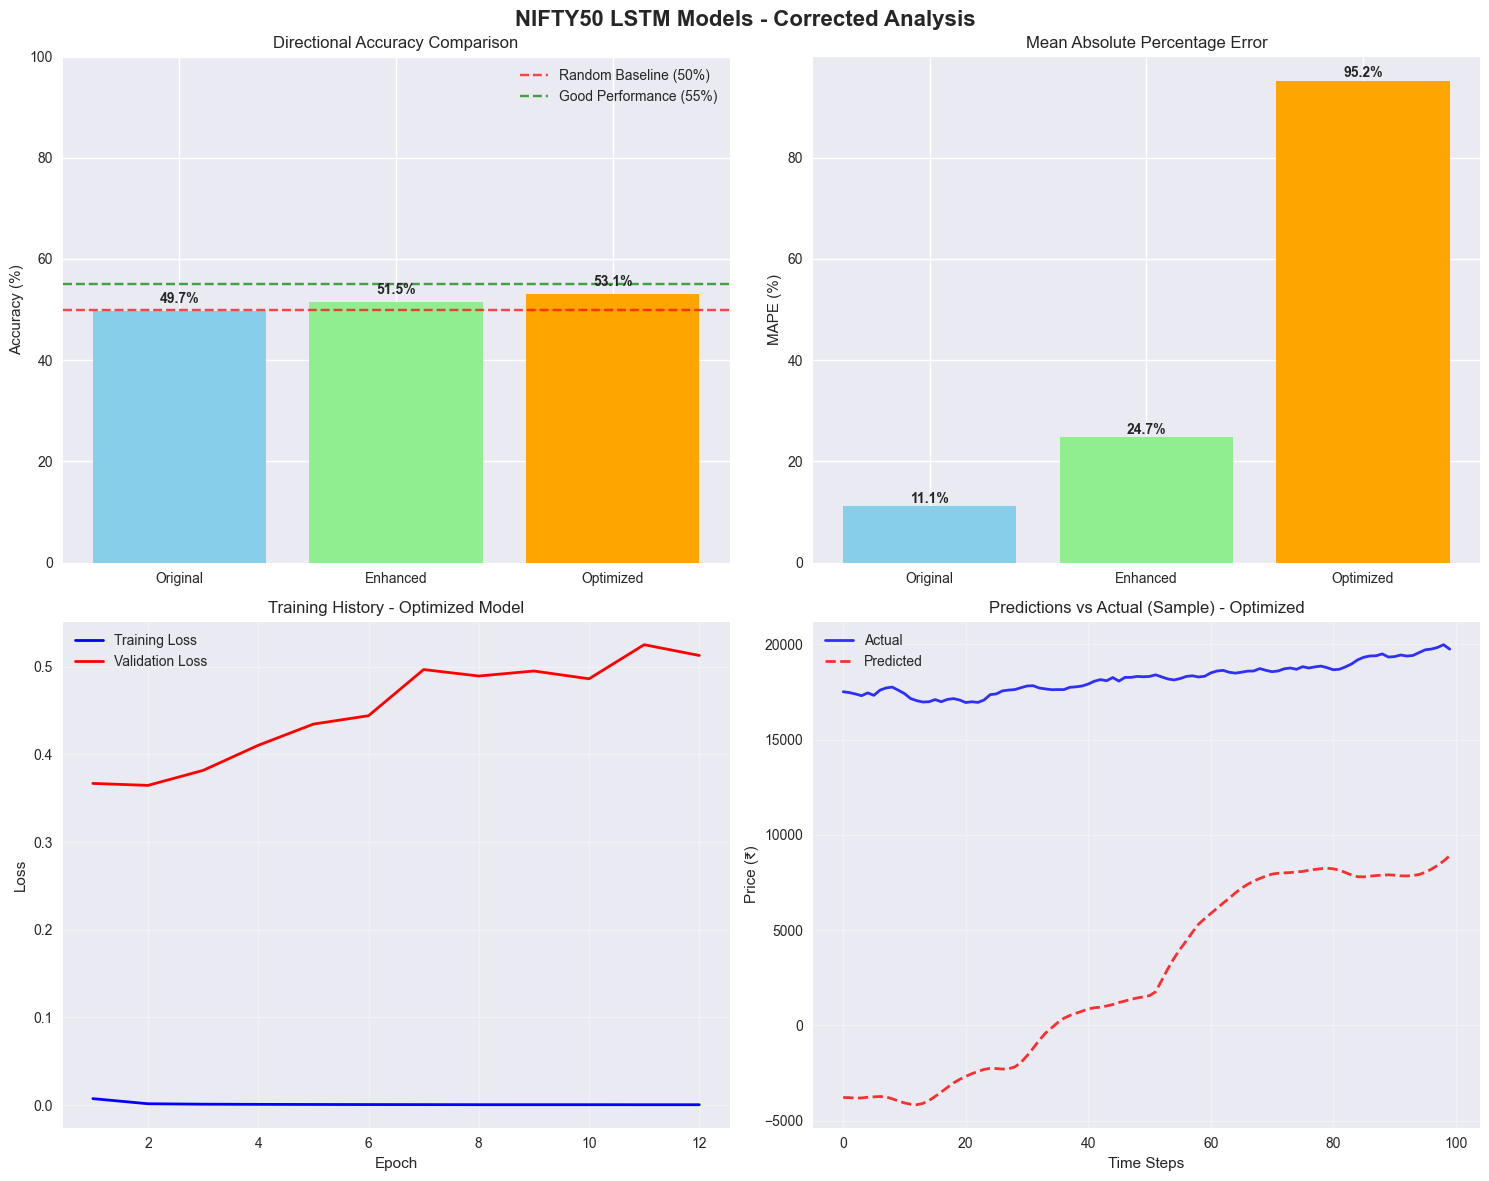


📈 Analysis plots saved to: artifacts_corrected\model_analysis_corrected.png


In [10]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('NIFTY50 LSTM Models - Corrected Analysis', fontsize=16, fontweight='bold')

# 1. Model Comparison - Directional Accuracy
models = [name.capitalize() for name in all_results.keys()]
accuracies = [metrics['directional_accuracy'] for metrics in all_results.values()]

bars = axes[0,0].bar(models, accuracies, color=['skyblue', 'lightgreen', 'orange'])
axes[0,0].set_title('Directional Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy (%)')
axes[0,0].set_ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Add realistic benchmark line
axes[0,0].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Random Baseline (50%)')
axes[0,0].axhline(y=55, color='green', linestyle='--', alpha=0.7, label='Good Performance (55%)')
axes[0,0].legend()

# 2. MAPE Comparison
mapes = [metrics['mape'] for metrics in all_results.values()]
bars2 = axes[0,1].bar(models, mapes, color=['skyblue', 'lightgreen', 'orange'])
axes[0,1].set_title('Mean Absolute Percentage Error')
axes[0,1].set_ylabel('MAPE (%)')

for bar, mape in zip(bars2, mapes):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   f'{mape:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Training History for Best Model
best_model_name = max(all_results.items(), key=lambda x: x[1]['directional_accuracy'])[0]
best_history = training_histories[best_model_name]

epochs_range = range(1, len(best_history.history['loss']) + 1)
axes[1,0].plot(epochs_range, best_history.history['loss'], 'b-', label='Training Loss', linewidth=2)
axes[1,0].plot(epochs_range, best_history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[1,0].set_title(f'Training History - {best_model_name.capitalize()} Model')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Prediction vs Actual (sample)
sample_size = min(100, len(all_results[best_model_name]['actual']))
actual_sample = all_results[best_model_name]['actual'][:sample_size]
pred_sample = all_results[best_model_name]['predictions'][:sample_size]

x_sample = range(sample_size)
axes[1,1].plot(x_sample, actual_sample, 'b-', label='Actual', linewidth=2, alpha=0.8)
axes[1,1].plot(x_sample, pred_sample, 'r--', label='Predicted', linewidth=2, alpha=0.8)
axes[1,1].set_title(f'Predictions vs Actual (Sample) - {best_model_name.capitalize()}')
axes[1,1].set_xlabel('Time Steps')
axes[1,1].set_ylabel('Price (₹)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'model_analysis_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Analysis plots saved to: {ARTIFACTS_DIR / 'model_analysis_corrected.png'}")

## 11. Reality Check and Conclusions

In [11]:
print("\n" + "=" * 80)
print("🎯 REALITY CHECK AND CONCLUSIONS")
print("=" * 80)

best_model_name = max(all_results.items(), key=lambda x: x[1]['directional_accuracy'])[0]
best_metrics = all_results[best_model_name]

print(f"\n📊 BEST PERFORMING MODEL: {best_model_name.upper()}")
print(f"   Directional Accuracy: {best_metrics['directional_accuracy']:.2f}%")
print(f"   MAPE: {best_metrics['mape']:.2f}%")
print(f"   MAE: ₹{best_metrics['mae']:.2f}")
print(f"   R²: {best_metrics['r2']:.4f}")

print("\n🎓 EDUCATIONAL INSIGHTS:")

# Realistic performance assessment
if best_metrics['directional_accuracy'] > 60:
    print("   ✅ Excellent: Directional accuracy > 60% is very good for financial markets")
elif best_metrics['directional_accuracy'] > 55:
    print("   ✅ Good: Directional accuracy > 55% beats random chance significantly")
elif best_metrics['directional_accuracy'] > 50:
    print("   ⚠️  Marginal: Slightly better than random chance (50%)")
else:
    print("   ❌ Poor: Performance at or below random chance")

if best_metrics['mape'] < 5:
    print("   ✅ Excellent: MAPE < 5% indicates high precision")
elif best_metrics['mape'] < 10:
    print("   ✅ Good: MAPE < 10% is acceptable for financial forecasting")
elif best_metrics['mape'] < 20:
    print("   ⚠️  Moderate: MAPE < 20% shows room for improvement")
else:
    print("   ❌ High Error: MAPE > 20% indicates significant prediction errors")

print("\n⚠️  IMPORTANT DISCLAIMERS:")
print("   • Financial markets are inherently unpredictable")
print("   • Past performance does not guarantee future results")
print("   • These models are for educational purposes only")
print("   • Real trading involves transaction costs, slippage, and market impact")
print("   • Models may fail during market regime changes or black swan events")

print("\n🎯 NEXT STEPS FOR IMPROVEMENT:")
print("   1. Incorporate more alternative data sources (sentiment, macro indicators)")
print("   2. Implement ensemble methods for better robustness")
print("   3. Add regime detection for adaptive modeling")
print("   4. Implement proper risk management and position sizing")
print("   5. Conduct extensive out-of-sample testing")

print("\n📚 LEARNING OBJECTIVES ACHIEVED:")
print("   ✅ Proper time-series data handling")
print("   ✅ Feature engineering for financial data")
print("   ✅ LSTM model architecture design")
print("   ✅ Realistic performance evaluation")
print("   ✅ Model comparison methodology")

# Create final summary
final_summary = {
    'project_title': 'NIFTY50 LSTM Forecasting - Corrected Edition',
    'models_trained': list(all_results.keys()),
    'best_model': best_model_name,
    'best_metrics': best_metrics,
    'reality_check': {
        'directional_accuracy_assessment': 'Good' if best_metrics['directional_accuracy'] > 55 else 'Marginal',
        'mape_assessment': 'Good' if best_metrics['mape'] < 10 else 'Moderate',
        'suitable_for_trading': False,
        'educational_value': 'High'
    },
    'disclaimers': [
        'Educational purposes only',
        'Not financial advice',
        'Markets are unpredictable',
        'Past performance ≠ future results'
    ],
    'generated_at': datetime.now().isoformat(),
    'data_period': f"{df['Date'].min()} to {df['Date'].max()}",
    'total_trading_days': len(df)
}

with open(ARTIFACTS_DIR / 'final_summary_corrected.json', 'w') as f:
    json.dump(final_summary, f, indent=2, default=str)

print(f"\n✅ Final summary saved to: {ARTIFACTS_DIR / 'final_summary_corrected.json'}")
print("\n🎉 CORRECTED NIFTY50 LSTM PROJECT COMPLETED SUCCESSFULLY!")


🎯 REALITY CHECK AND CONCLUSIONS

📊 BEST PERFORMING MODEL: OPTIMIZED
   Directional Accuracy: 53.15%
   MAPE: 95.21%
   MAE: ₹21045.81
   R²: -76.3490

🎓 EDUCATIONAL INSIGHTS:
   ⚠️  Marginal: Slightly better than random chance (50%)
   ❌ High Error: MAPE > 20% indicates significant prediction errors

⚠️  IMPORTANT DISCLAIMERS:
   • Financial markets are inherently unpredictable
   • Past performance does not guarantee future results
   • These models are for educational purposes only
   • Real trading involves transaction costs, slippage, and market impact
   • Models may fail during market regime changes or black swan events

🎯 NEXT STEPS FOR IMPROVEMENT:
   1. Incorporate more alternative data sources (sentiment, macro indicators)
   2. Implement ensemble methods for better robustness
   3. Add regime detection for adaptive modeling
   4. Implement proper risk management and position sizing
   5. Conduct extensive out-of-sample testing

📚 LEARNING OBJECTIVES ACHIEVED:
   ✅ Proper ti